In [3]:
# This is the implementation of 
# modeling coding mutations using 
# ElasticNet to predict drug response 
# (AUC) in CCLE dataset.
# Data: 1/2/2022

"""Training schema: 1. Bootstrapping 80% of the data (FUNCTION "drug_model")
                    2. Outter loop to split resampled data into 5 folds for training and 
                         validation (implemented in FUNCTION "out_loop" )
                    3. During each iteration of training, apply inner 10-fold  cross 
                       validation to select best l1 ratio and alpha pair. (FUNCTION EN_cv_in)
                    4. Vaildate on the 5th fold testing set. 
""" 
%matplotlib inline
import pandas as pd
import numpy as np 
import os
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from tqdm import tqdm
import math
import matplotlib.pyplot as plt
import warnings
from functools import reduce
from tools import write_file
import argparse
import tools
import importlib
importlib.reload(tools)
from pprint import pprint 

In [20]:
# SET FILE PATHS
path = '/Users/jerryliu/Documents/Vu_uva/internship/CCLE/mutation_files/' # dir contains mutation data 
file_list = ['damaging','hotspot','nonconserving','otherconserving'] # four mutation vectors 
#drug_path = '/Users/jerryliu/Documents/Vu_uva/internship/CCLE/primary-screen-replicate-collapsed-logfold-change.csv'                 
drug_path = "/Users/jerryliu/Documents/Vu_uva/internship/CCLE/CCLE_NP24.2009_Drug_data_2015.02.24.csv" # drug reponse 
drug_path = "/Users/jerryliu/Documents/Vu_uva/internship/CCLE/Drug_sensitivity_AUC.csv"
out_path = '/Users/jerryliu/jerry_jupyter/internship/files/output/' #dir to store predictions
Con_file='/Users/jerryliu/Documents/Vu_uva/internship/CCLE/mutation_files/Census_allSat.csv' # Cosmic gene
                                                                                             # list
sample_info = "/Users/jerryliu/Documents/Vu_uva/internship/CCLE/sample_info.csv"

In [21]:
# **Source of the data**:
# Mutation vectors: https://depmap.org/portal/download/    (version: Depmap Public 2021Q4 )
# Drug response data: https://depmap.org/portal/download/   (CUSTOMS DOWNLOADS -> compound 
#                                                               -> Drug sensitivity AUC (CTD^2)
# Cancer gene census: https://cancer.sanger.ac.uk/cosmic/census?genome=37    (in total 729 genes)

In [22]:
#read drug sensitivity files. 
def read_drug(drug_path):
    """ READ DRUG RESPONSE FILE
    return a matrix with cell line ids as row index
    """
    drug_data = pd.read_csv(drug_path)
    drug_data = drug_data.set_index(drug_data.columns[0])
    return(drug_data)

In [7]:
#funtion to merge two mutation files.
def merge_mt(m_f1, m_f2, drug_id, gene_filter = False):
    """ INPUT: [m_f1, m_f2]:  two mutation data matrices 
                    drug_id:  cell line ids in drug response data 
                    gene_filter: * If False:  Merged cell lines =  (m_f1 | drug cl) & (m_f2 | drug cl) 
                                 * If True: merged cell lines = (m_f1 | m_f2) 
                                 * by default (False), the idea is to take union of cell lines from two 
                                   mutation datasets with valid drug reponse targets. For column, we take 
                                   union of genes from two sets. 
        OUTPUT: merged data frame
        FUNCTION: merge two mutation vectors, if a gene has a mutation record (1) in either of the 
                  two vectors, then it is a 1 in the merged data set.
    """
    
    # input: dataframe with index as cell line id. 
    # output: merged dataframe
    #cell lines: m_f1 & m_f2;  cancer genes: m_f1 | m_f2.
    if not gene_filter:
        cl_id = set.union(set.intersection(set(m_f1.index), set(drug_id)), 
                         set.intersection(set(m_f2.index), set(drug_id)))
    else:
        cl_id = set.intersection(set(m_f1.index), set(m_f2.index))
        
    gene_id = set.union(set(m_f1.columns), set(m_f2.columns))

    m_f1 = m_f1.reindex(cl_id, columns = gene_id, fill_value = 0 )
    m_f2 = m_f2.reindex(cl_id, columns = gene_id, fill_value = 0)
    #combine the two files.
    m_comb = pd.DataFrame(np.where(m_f1 == 0, m_f2, m_f1), index = cl_id, columns=gene_id)
    
    return(m_comb)

In [8]:

def EN_cv_in(x_train, y_train, fold, alpha, l1_ratio):
        """
        INPUT: training set. (each alpha, l1_ratio parameter)
        OUTPUT: averge spearman correlation score of 10 results
        FUNCTION: conduct 10 cross validation on the 80 % of resampled dataset
                  to determine the best l1_ratio and alpha pair.
        """
        #alpha = p1, l1_ratio = p2
        kf_in = KFold(n_splits = fold)
        cv_perf = np.array([]) 
        for random_, (train_in, test_in) in enumerate(kf_in.split(x_train)):

            x_train_in, x_test_in, y_train_in, y_test_in = x_train[train_in], x_train[test_in], y_train[train_in], y_train[test_in]

            #build model with each combination of parameters. 
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                regr = ElasticNet(random_state = random_, alpha= alpha, l1_ratio=l1_ratio, 
                                  fit_intercept = False, max_iter= 3000)
                regr.fit(x_train_in, y_train_in)
                
            y_pre = regr.predict(x_test_in)
            #perforamance matrix of the model is the Pearson's corrlation coeeficient r. 
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                r = pd.Series(y_pre).corr(pd.Series(y_test_in), method = 'spearman')
                cv_perf = np.append(cv_perf,[r])
                del regr
        return(np.mean(cv_perf))

    
def out_loop(x, y_total, cl_id, out_cv_fold= 5):
    ''' 5 fold cv (outter-loop)
    # x: (#_(80%)C, #_genes); y: (#_(80%)C,)
    FUNCTION: conduct 5-fold cross validation on the resampled data. In each iteration, conduct
              10 fold CV on the training set (EN_cv_in function) to do parameter search and select the l1
              ratio and alpha with highest validation score on the 10th fold testing set
    '''
    kf = KFold(n_splits = out_cv_fold)
    pre_y_array = dict(list(zip(cl_id,[ [] for _ in range(len(cl_id))])))
    per_test_list = []
    for train, test in kf.split(x):
        x_train, x_test, y_train, y_test = x.values[train], x.values[test], y_total.values[train], y_total.values[test]
        train_label, test_label = x.index[train], x.index[test]
        # 10-fold in x_train (inner-loop). 
        # each pair of alpha and l1_ratio, do cross training to sellect best pair. 

        l1_ratio_list = np.linspace(start = 0.2, stop = 1.0, num = 5) #10 values
        alpha_list =  np.array([math.exp(i) for i in np.arange(-6, 5, 0.8)] ) # 250 values
        #alpha_list =  np.array([math.exp(i) for i in np.arange(-8,5,0.8)]) #  values
        para_matrix = {(l1_ratio, alpha):0 for l1_ratio in l1_ratio_list for alpha in alpha_list}

        for (l1_ratio, alpha) in para_matrix:
            #do ten fold cv to sellect best parameter pairs. 
            ave_per = EN_cv_in(x_train= x_train, y_train = y_train, fold = 8, alpha = alpha, l1_ratio= l1_ratio)
            para_matrix[(l1_ratio, alpha)] = ave_per
        print(para_matrix)
        
        #return the best alpha-l1-ratio pair.
        op_l1_ratio, op_alpha = pd.Series(para_matrix).idxmax() 
        print('the best validation performance is: ', para_matrix[(op_l1_ratio, op_alpha)])
        
        #predict on the 5th-fold set (testing set)
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            regr = ElasticNet(random_state=0, alpha= op_alpha, l1_ratio = l1_ratio, 
                              fit_intercept = False, max_iter= 3000)
            regr.fit(x_train, y_train)
            y_pre = regr.predict(x_test)
            
        if len(np.unique(y_pre) ) == 1: print('constant prediction.')
        del regr
        #add results to the storage dictionary. 
        for index, value in zip(test_label, y_pre): pre_y_array[index].append(value)
        per_test = pd.Series(y_pre).corr(pd.Series(y_test),method = 'spearman') 
        per_test_list.append(per_test)
        print('performance on the test set is:', per_test)
        plt.scatter(y_test, y_pre)
        plt.xlabel('test set')
        plt.ylabel('prediction')
        plt.show()
        #break
    #add the prediction to the list.
    pre_y_array = pd.Series(pre_y_array).reindex(cl_id)
    
    return(pre_y_array, per_test_list)


def drug_model(m_file, target, out_path):
    """
    INPUT: m_file mutation matrix with unpreprocessed binery values.
    OUTPUT: mean prediction values of 10 iterations (TYPE: pd.Sereis).
    FUNCTION: conduct normalization + 10 times of 5-fold crossvalidation
    """
    #eliminate cell lines with nan drug sensitivity data.
    drug_name = target.name
    Y = target.dropna()
    m_file_notna = m_file.loc[Y.index,:]

    #normalize the each col to have ~0 mean and ~1 sd. 
    # old normalization method:
    # norm_m_file = (m_file_notna - m_file_notna.mean(axis = 0)) / m_file_notna.std(axis = 0)
    norm_m_file = tools.scal_matrix(m_file_notna)
    
    print('### normalize with mean=0, std = 1.')
    norm_m_file.dropna(axis = 1, inplace = True)
    print('number of features selected {}'.format(norm_m_file.shape[1]))
    X, Y_total = norm_m_file, Y
    
    ### EN model
    ## bootstraping (80% of data) for 10 times. 
    ## each time with 80% data for training and remaining 20% for
    ## testing (5 fold CV).
    cl_id = norm_m_file.index
    Y_pre_array = pd.Series(dict(list(zip(cl_id, [[] for i in range(cl_id.shape[0])]))),
                            index = cl_id, name = drug_name)
    cv_result_list = []
    for i in tqdm(range(10)):
        print('iteration {} begains'.format(i))
        #resample 80% of data
        x, y_total = resample(X, Y_total, replace = False, n_samples = int(X.shape[0]*0.9), random_state = i)
        print(X.isna().sum().sum())
        print(y_total.isna().sum().sum())

        #outter loop with 5 fold cv.
        prediction, cv_list = out_loop(x = x, y_total= y_total, cl_id = cl_id, out_cv_fold=5 )
        cv_result_list.extend(cv_list)
        print('iter {}, outter loop finished. '.format(i))
        
        for i in prediction.index: Y_pre_array[i].extend(prediction[i])

    
    ##calculate the mean of 10 iterations. 
    #Y_pre_array = Y_pre_array.map(np.mean)
    tools.write_file(Y_pre_array, 'comp_{}.csv'.format(drug_name), out_path)
    # list of cross validation results. 
    return(cv_result_list)


In [23]:
#def main():
#STEP 1. ---> load data <---
sample_info = pd.read_csv(sample_info)
m_f1, m_f2, m_f3, m_f4  = file_list
m_f1 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f1 + '.csv', index_col = 0)
m_f2 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f2 + '.csv', index_col = 0)
m_f3 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f3 + '.csv', index_col = 0)
m_f4 = pd.read_csv(path + 'CCLE_mutations_bool_' + m_f4 + '.csv', index_col = 0)
print('#### reading files completed')

#### reading files completed


In [24]:
#STEP 2.1 ---> define target cancer genes <---
gene_bankmap = {gene.split(' ')[0]:gene.split(' ')[1] 
 for gene in tools.get_cons(m_f1.columns, m_f2.columns, m_f3.columns, method='union')}

Con_genes = pd.read_csv(Con_file).loc[:,'Gene Symbol'] # Get Cosmis gene list
gene_lists =  [ m_file.columns.map(lambda x:x.split(' ')[0])  # Get union of three gene lists
    for m_file in [m_f1, m_f2, m_f3] ]                        # in mutation files. Here we use first
                                                              # three (m_f1, m_f2, m_f3) mutation vectors.
final_genes = tools.get_cons(tools.get_cons(*gene_lists, method='union'), 
               Con_genes, method = 'inter')  # We take intersection of the Cosmic and CCLE gene list. 
final_genes = [f"{gene} {gene_bankmap[gene]}" for gene in final_genes ]
print(f'number of final genes is {len(final_genes)}')

number of final genes is 710


In [25]:
def map_id(CCLE_name):
    DepMap_ID = sample_info.loc[:,"DepMap_ID"][sample_info.CCLE_Name.values == CCLE_name]
    if len(DepMap_ID) == 0: 
        return np.NAN
    return DepMap_ID.values[0]

In [12]:
# STEP 2.2 process drug data

# drug_data = read_drug(drug_path = drug_path)
# drug_data = drug_data.reset_index().loc[:,["CCLE Cell Line Name", "Compound", "ActArea" ]].set_index(["CCLE Cell Line Name", "Compound"])
# drug_data = drug_data.sort_index().unstack()

# # step 2.2.1 map the CCLE names to DepMap_ID
# #sample_info.loc[:,['CCLE_Name', 'DepMap_ID'] ]
# drug_data.columns = drug_data.columns.map(lambda x:x[1])
# drug_data

In [13]:
# drug_data.set_index(drug_data.index.map(map_id), inplace=True)

# drug_data = drug_data.loc[drug_data.index.notna(),:]

In [26]:
drug_data =  read_drug(drug_path = drug_path)
# Only select single-drug treatment.
drug_data = drug_data.loc[:,drug_data.columns[drug_data.columns.map(lambda x: len(x.split(' ')[0].split(':'))) == 1]]
drug_data.columns = drug_data.columns.map(lambda x: x.split('(CTRP')[0].strip())
print(drug_data.shape)
drug_data.head()


(815, 494)


,CIL56,FQI-1,BRD-K92856060,B02,BRD6340,BRD-K45681478,ML050,ML162,CIL41,ML006,...,AT13387,BCL-LZH-4,skepinone-L,BRD-K34222889,PF-4800567,avicin D,BRD-K30748066,linsitinib,AT-406,ML031
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
ACH-000002,NaN,NaN,13.349,12.987,14.904,13.517,14.709,10.4670,NaN,14.634,...,7.0509,15.139,14.489,10.7010,15.740,12.6930,NaN,11.682,14.231,13.676
ACH-000004,11.733,10.825,13.911,13.445,14.193,15.000,15.689,7.0524,14.780,14.513,...,NaN,NaN,NaN,9.9767,NaN,NaN,NaN,16.917,NaN,15.715
ACH-000005,NaN,NaN,13.646,12.313,13.739,13.328,14.662,6.7487,NaN,14.532,...,4.3041,14.460,13.254,10.5430,14.575,9.9691,NaN,16.538,14.004,12.914
ACH-000006,NaN,NaN,NaN,NaN,14.016,11.103,NaN,9.8786,NaN,NaN,...,NaN,NaN,NaN,9.2081,NaN,NaN,NaN,12.054,13.839,NaN
ACH-000007,14.562,11.469,14.418,12.920,14.742,12.056,15.638,8.5650,15.313,14.302,...,NaN,NaN,NaN,10.5100,NaN,NaN,NaN,11.212,NaN,14.694


(812, 1854)


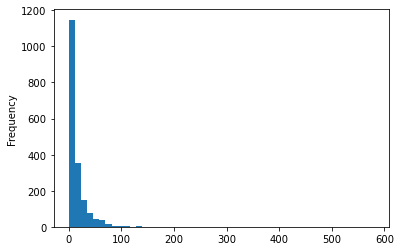

In [27]:
# STEP 2.2 ---> concact three mutation matrix instead of mergeing genes ---
inter_cls = set.intersection(set(m_f1.index), set(m_f2.index), set(m_f3.index), set(drug_data.index))
m_f1_ = tools.trans_genes(m_f1, Con_genes, gene_bankmap).loc[inter_cls,:]
m_f2_ = tools.trans_genes(m_f2, Con_genes, gene_bankmap).loc[inter_cls,:]
m_f3_ = tools.trans_genes(m_f3, Con_genes, gene_bankmap).loc[inter_cls,:]
m_file = pd.concat([m_f1_, m_f2_, m_f3_], axis=1)
(m_file == 1).sum().plot.hist(bins = 50)
print(m_file.shape)

In [16]:
# STEP 2.2 ---> merge mutation files <---
m_file = merge_mt(merge_mt(m_f1, m_f2, drug_id=drug_data.index), m_f3, 
                  drug_id= drug_data.index,gene_filter=False)      # Merge m_f1, m_f2, m_f3 CCLE
                                                                   # mutation metrices.

print('#### merging mutation files completed')

m_file = m_file.loc[:,final_genes] # Now we take selected 710 genes.
print(m_file.shape)
m_file.head()

#### merging mutation files completed
(812, 710)


,MECOM (2122),PTPRD (5789),WWTR1 (25937),ARID2 (196528),IL7R (3575),NUP98 (4928),CBL (867),TRIM27 (5987),BAX (581),TPR (7175),...,CEBPA (1050),ISX (91464),EED (8726),SS18L1 (26039),NCOR1 (9611),CTNNA2 (1496),BCL3 (602),HLA-A (3105),VAV1 (7409),TCF3 (6929)
ACH-001130,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACH-000791,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ACH-000310,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ACH-000353,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
ACH-001306,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
# STEP 3. ---> process drug labels <---
# get rid of drugs with too many missing values.
thresh  = int(m_file.shape[0]*(0.60)) ## at least 80% of Non-na value in each drug
drug_df = drug_data.loc[m_file.index,:].dropna(axis = 1, thresh = thresh)
print(f'before filtering drugs: the number of drugs is {drug_data.shape[1]}')
print(f'after filtering, the number of drugs is {drug_df.shape[1]}')
print(f'Shape of drug data: {drug_df.shape}')
drug_df.head()

before filtering drugs: the number of drugs is 494
after filtering, the number of drugs is 392
Shape of drug data: (812, 392)


,BRD-K92856060,B02,BRD6340,BRD-K45681478,ML050,ML162,ML006,NSC30930,Bax channel blocker,MI-1,...,alpelisib,GSK2636771,JW-74,necrosulfonamide,HBX-41108,palmostatin B,BRD-K03536150,BRD-K34222889,linsitinib,ML031
ACH-001130,12.746,12.568,14.206,13.511,14.414,6.3755,14.222,14.808,12.577,14.193,...,14.314,14.494,13.139,11.107,11.86,15.779,12.199,9.3039,13.960,13.559
ACH-000791,14.616,16.785,14.492,NaN,14.781,9.0860,13.534,14.828,14.771,14.690,...,NaN,NaN,NaN,NaN,NaN,NaN,13.418,13.7190,15.533,15.000
ACH-000019,13.947,14.542,14.429,15.072,NaN,12.9990,15.538,14.160,13.583,16.273,...,NaN,NaN,NaN,NaN,NaN,NaN,15.000,10.9020,13.454,14.863
ACH-000377,16.606,14.517,14.303,NaN,14.805,10.6680,14.663,14.217,13.732,14.488,...,NaN,NaN,NaN,NaN,NaN,NaN,12.898,10.1370,14.818,14.599
ACH-000152,15.223,11.796,14.566,14.495,14.566,6.8633,15.142,14.905,NaN,14.918,...,13.294,14.276,14.032,11.881,13.13,15.185,14.022,11.4580,15.359,12.772


In [27]:
# STEP 4. preprocessing the data 

comp_index = 179  #we build a model for the first drug
target = drug_df.iloc[:,comp_index]
print(f'drug name is {target.name}')

# preprocess
# eliminate cell lines with nan drug sensitivity data.
drug_name = target.name
Y = target.dropna()
m_file_notna = m_file.loc[Y.index,:]

drug name is 17-AAG


In [15]:
#normalize the each col to have ~0 mean and ~1 sd. 
#norm_m_file = (m_file_notna - m_file_notna.mean(axis = 0)) / m_file_notna.std(axis = 0)
from sklearn import preprocessing
#(m_file_notna == 1).sum().plot.hist(bins=50)
norm_m_file = tools.scal_matrix(m_file_notna)

In [16]:
norm_m_file.dropna(axis = 1, inplace = True) # Drop genes if it is NAN after normalization 
print('number of features (genes) is: {}'.format(norm_m_file.shape[1]))
norm_m_file.head()
####################
# After normalization many columns are close to 0 and have missing values, 
# so they have to be thrown out. I am wondering if this way of normalization is done rightly?
###################

number of features (genes) is: 1854


,ATRX (546),STAT6 (6778),BTG1 (694),IL7R (3575),DDX5 (1655),FEV (54738),CCNC (892),PPP6C (5537),EBF1 (1879),SS18L1 (26039),...,RAD21 (5885),BTG2 (7832),ASXL2 (55252),GATA2 (2624),BCL9 (607),PCBP1 (5093),IL2 (3558),NFKB2 (4791),LRP1B (53353),WT1 (7490)
ACH-000758,-0.121395,-0.112272,-0.045596,-0.091478,-0.079139,0.0,-0.045596,-0.06455,-0.102383,-0.045596,...,-0.159787,-0.06455,-0.185296,-0.13794,-0.185296,-0.129914,-0.112272,-0.145556,1.756344,-0.121395
ACH-000889,-0.121395,-0.112272,-0.045596,-0.091478,-0.079139,0.0,-0.045596,-0.06455,-0.102383,-0.045596,...,-0.159787,-0.06455,-0.185296,-0.13794,-0.185296,-0.129914,-0.112272,-0.145556,-0.569364,-0.121395
ACH-000775,-0.121395,-0.112272,-0.045596,-0.091478,-0.079139,0.0,-0.045596,-0.06455,-0.102383,-0.045596,...,-0.159787,-0.06455,-0.185296,-0.13794,-0.185296,-0.129914,-0.112272,-0.145556,1.756344,-0.121395
ACH-001190,-0.121395,-0.112272,-0.045596,-0.091478,-0.079139,0.0,-0.045596,-0.06455,-0.102383,-0.045596,...,-0.159787,-0.06455,-0.185296,-0.13794,-0.185296,-0.129914,-0.112272,-0.145556,-0.569364,-0.121395
ACH-000435,-0.121395,-0.112272,-0.045596,-0.091478,-0.079139,0.0,-0.045596,-0.06455,-0.102383,-0.045596,...,-0.159787,-0.06455,-0.185296,-0.13794,-0.185296,-0.129914,-0.112272,-0.145556,1.756344,-0.121395


In [118]:
# STEP 5. Building the elasticNET model 
# NOTE: HERE only applied 5 fold cv to check if 
# the whole code works. The actual validation schema used 
# is implemented in drug_model FUNCTION (Complete double loop 
# validation cell). 
############################################################
X, Y_total = norm_m_file, Y

# Five fold cross validation 
kf = KFold(n_splits = 5)

per_test_list = []
l1_ratio_list = np.linspace(start = 0.2, stop = 1.0, num = 5) #10 values
alpha_list =  np.array([math.exp(i) for i in np.arange(-15,5,2)] ) # 250 values
#alpha_list =  np.array([math.exp(i) for i in np.arange(-8,5,0.8)]) #  values
para_matrix = {(l1_ratio, alpha):[] for l1_ratio in l1_ratio_list for alpha in alpha_list}

for random_, (train, test) in enumerate(kf.split(X)):
    x_train, x_test, y_train, y_test = X.values[train], X.values[test], Y_total.values[train], Y_total.values[test]

    for randn_, (l1_ratio, alpha) in enumerate(para_matrix):
        #do ten fold cv to sellect best parameter pairs. 
        with warnings.catch_warnings():
            warnings.simplefilter('ignore')
            regr = ElasticNet(random_state = random_, alpha= alpha, l1_ratio=l1_ratio, 
                              fit_intercept = True, max_iter=3000)
            regr.fit(x_train, y_train)
            pre = regr.predict(x_test)
            r = pd.Series(pre).corr(pd.Series(y_test), method = 'spearman')
            para_matrix[(l1_ratio, alpha)].append(r)
            
#             plt.scatter(y_test, pre)
#             plt.xlabel('test set')
#             plt.ylabel('prediction')
#             plt.show()
    print('a cv just done')

a cv just done
a cv just done
a cv just done
a cv just done
a cv just done


In [125]:
#para_matrix

In [123]:
#show best performance of each parameter search 
best=0
for pra, pre_list in para_matrix.items():
    pre_list = np.array(pre_list)
    if np.isnan(pre_list).sum() != len(pre_list):
        MAX =  np.max(pre_list[~np.isnan(pre_list)]) 
        best = MAX if best <= MAX else best
print(best)

0.3656769408794445


## [Complete double loop validation]

  0%|          | 0/10 [00:00<?, ?it/s]

### normalize with mean=0, std = 1.
number of features selected 1854
iteration 0 begains
0
0
{(0.2, 0.0024787521766663585): -0.02952245193837679, (0.2, 0.0055165644207607716): -0.03321348702796484, (0.2, 0.012277339903068436): -0.026186374824967277, (0.2, 0.027323722447292545): -0.030267006019326605, (0.2, 0.060810062625217924): -0.03067689482181816, (0.2, 0.13533528323661256): -0.02528249173967604, (0.2, 0.30119421191220175): -0.018130918981744834, (0.2, 0.6703200460356384): -0.00742197006359668, (0.2, 1.4918246976412681): -0.014442840879452577, (0.2, 3.3201169227365424): 0.03335242389327095, (0.2, 7.389056098930637): nan, (0.2, 16.444646771097002): nan, (0.2, 36.59823444367791): nan, (0.2, 81.450868664968): nan, (0.4, 0.0024787521766663585): -0.02122708727409471, (0.4, 0.0055165644207607716): -0.020480927221854114, (0.4, 0.012277339903068436): -0.020972027262691373, (0.4, 0.027323722447292545): -0.020278028636517963, (0.4, 0.060810062625217924): -0.020979244547854502, (0.4, 0.1353352

/Users/jerryliu/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


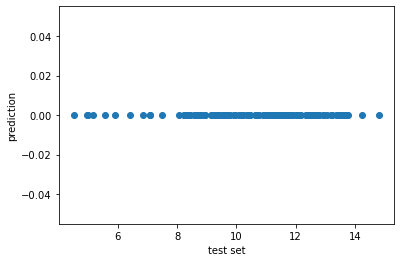

{(0.2, 0.0024787521766663585): 0.03383872147049344, (0.2, 0.0055165644207607716): 0.02477105436639654, (0.2, 0.012277339903068436): 0.03186470394306027, (0.2, 0.027323722447292545): 0.027155438998036685, (0.2, 0.060810062625217924): 0.029383201863014942, (0.2, 0.13533528323661256): 0.024688124694210088, (0.2, 0.30119421191220175): 0.020378564415508046, (0.2, 0.6703200460356384): 0.017425629655212126, (0.2, 1.4918246976412681): 0.019999611095738924, (0.2, 3.3201169227365424): 0.03239936023799683, (0.2, 7.389056098930637): nan, (0.2, 16.444646771097002): nan, (0.2, 36.59823444367791): nan, (0.2, 81.450868664968): nan, (0.4, 0.0024787521766663585): 0.035726685298398134, (0.4, 0.0055165644207607716): 0.033421276674185485, (0.4, 0.012277339903068436): 0.038302443608002154, (0.4, 0.027323722447292545): 0.03930159091683305, (0.4, 0.060810062625217924): 0.03710355279362045, (0.4, 0.13533528323661256): 0.026931098443974344, (0.4, 0.30119421191220175): 0.023018367831237625, (0.4, 0.6703200460356

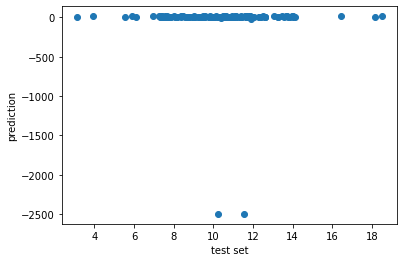

{(0.2, 0.0024787521766663585): 0.007949196862636457, (0.2, 0.0055165644207607716): 0.011998394160488814, (0.2, 0.012277339903068436): 0.008867940070713131, (0.2, 0.027323722447292545): 0.010076602077565255, (0.2, 0.060810062625217924): 0.008918359586781464, (0.2, 0.13533528323661256): 0.007548888957500508, (0.2, 0.30119421191220175): 0.004345687054911836, (0.2, 0.6703200460356384): -0.0038492641485441126, (0.2, 1.4918246976412681): -0.009215719976763403, (0.2, 3.3201169227365424): 0.04381259814627493, (0.2, 7.389056098930637): nan, (0.2, 16.444646771097002): nan, (0.2, 36.59823444367791): nan, (0.2, 81.450868664968): nan, (0.4, 0.0024787521766663585): 0.008402126549041242, (0.4, 0.0055165644207607716): 0.0070232742525109144, (0.4, 0.012277339903068436): 0.008446326977681162, (0.4, 0.027323722447292545): 0.008727230885595804, (0.4, 0.060810062625217924): 0.008008709503918094, (0.4, 0.13533528323661256): 0.007726030184570059, (0.4, 0.30119421191220175): -0.0007558064609553689, (0.4, 0.67

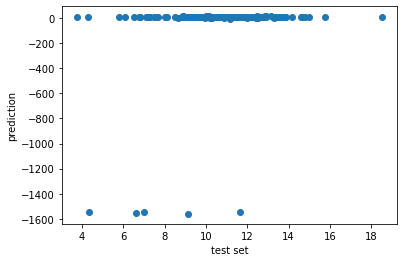

{(0.2, 0.0024787521766663585): -0.03491624579399976, (0.2, 0.0055165644207607716): -0.03901591711738915, (0.2, 0.012277339903068436): -0.03403230967633985, (0.2, 0.027323722447292545): -0.03616679420965287, (0.2, 0.060810062625217924): -0.039364849745148006, (0.2, 0.13533528323661256): -0.0418285772751193, (0.2, 0.30119421191220175): -0.04054427183593419, (0.2, 0.6703200460356384): -0.04002796500263806, (0.2, 1.4918246976412681): -0.03587875147049371, (0.2, 3.3201169227365424): -0.01497985991692722, (0.2, 7.389056098930637): nan, (0.2, 16.444646771097002): nan, (0.2, 36.59823444367791): nan, (0.2, 81.450868664968): nan, (0.4, 0.0024787521766663585): -0.03527546505288171, (0.4, 0.0055165644207607716): -0.03934768979930097, (0.4, 0.012277339903068436): -0.03915887148245155, (0.4, 0.027323722447292545): -0.04438455851670182, (0.4, 0.060810062625217924): -0.04366123148524061, (0.4, 0.13533528323661256): -0.04775043726665606, (0.4, 0.30119421191220175): -0.05066670610698922, (0.4, 0.6703200

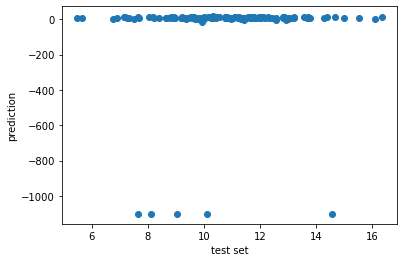

  0%|          | 0/10 [3:30:06<?, ?it/s]


KeyboardInterrupt: 

In [19]:

#build model for each drug.
"""Training schema: 1. Bootstrapping 80% of the data (FUNCTION "drug_model")
                    2. Outter loop to split resampled data into 5-folds for training and 
                         validation (implemented in FUNCTION "out_loop" )
                    3. During each iteration of training, apply inner 10-fold loop cross 
                       validation to select best l1 ratio and alpha pair. (FUNCTION EN_cv_in)
                    4. Vaildate on the 5th fold testing set. 
""" 

comp_index = 179
target = drug_df.iloc[:,comp_index]
pre = drug_model(m_file, target, out_path=out_path) 




    

In [ ]:
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("-t", "--target_index", type=int,
                        help= "target index (1-based)")
    parser.add_argument("-o","--output", type = str,
                        help= "output file's dir ")
    args = parser.parse_args()
    
    dg_index = args.target_index
    out_dir = args.output
    
    main()

## visualization 

In [64]:
drug_name = 'tanespimycin'



In [65]:
pre  =pd.read_csv(f'/Users/jerryliu/jerry_jupyter/internship/files/baseline_out/comp_{drug_name}.csv'
                 , index_col = 0)
pre = pre.iloc[:,0].map(lambda x:[ float(i) for i in x[1:-1].split(', ') ])
pre.map(np.mean)

ACH-000295      7.247570
ACH-001113      4.433661
ACH-000525      6.872820
ACH-000915   -246.256781
ACH-000479      5.294594
                 ...    
ACH-000116      7.981384
ACH-000794      5.831626
ACH-000562      6.630212
ACH-000960     -4.614323
ACH-000763      7.969216
Name: tanespimycin, Length: 775, dtype: float64

In [66]:
 drug_df.loc[pre.index,drug_name]

ACH-000295     9.2693
ACH-001113    13.6730
ACH-000525     9.4479
ACH-000915    11.5830
ACH-000479    13.4090
               ...   
ACH-000116    13.7970
ACH-000794     9.2198
ACH-000562    12.3500
ACH-000960    13.2830
ACH-000763     9.8498
Name: tanespimycin, Length: 775, dtype: float64

0.04891242112394785

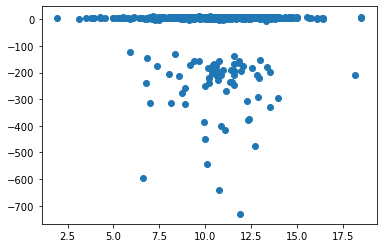

In [67]:
plt.scatter( drug_df.loc[pre.index,drug_name], pre.map(np.mean))
drug_df.loc[pre.index,drug_name].corr( pre.map(np.mean), method = 'spearman')

In [60]:
%matplotlib inline

In [76]:
path = '/Users/jerryliu/jerry_jupyter/internship/files/baseline_out/'
file_list = os.listdir(path)
drug_list = [i[5:-4] for i in file_list]
cor_list = []; index = []
for i in file_list:
    try:
        pre  =pd.read_csv(path+i, index_col = 0)
        pre = pre.iloc[:,0].map(lambda x:[ float(i) for i in x[1:-1].split(', ') ])
        test = drug_df.loc[pre.index,i[5:-4]]
    except:
        continue
    else:
        index.append(i[5:-4])
        cor_list.append(drug_df.loc[pre.index,drug_name].corr( pre.map(np.mean), method = 'spearman'))

In [80]:
pd.Series([100*i for i in cor_list], index = index).to_csv('/Users/jerryliu/jerry_jupyter/internship/files/results/baseline.ressult.csv')